# FNC 6.1 Basics of IVPs
This notebook implements and solves the programming parts from the IVP Basics exercises.

**Contents**
- Utility: RK4 solver
- Ex. 2: Solve the IVPs from Exercise 1 numerically and plot
- Ex. 5: Logistic with harvesting
- Ex. 6: Forced nonlinear ODE with multiple initial values and separatrix search
- Ex. 7: Caffeine concentration with piecewise input
- Ex. 8: Skydiver with piecewise drag, altitude and touchdown time

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

# Use a fixed-step classical RK4 for robustness and determinism.
def rk4(f, t_span, y0, dt):
    '''
    Integrate y' = f(t, y) on [t0, t1] with fixed step dt.
    Returns (t, y) with shapes (N,), (N, dim).
    '''
    t0, t1 = float(t_span[0]), float(t_span[1])
    if dt <= 0:
        raise ValueError("dt must be positive")
    n = int(np.ceil((t1 - t0) / dt))
    t = t0 + dt * np.arange(n + 1)
    t[-1] = t1  # exact end
    y = np.empty((n + 1, np.size(y0, axis=0) if np.ndim(y0) > 0 else 1), dtype=float)
    y[0] = np.atleast_1d(y0).astype(float)

    for k in range(n):
        h = t[k+1] - t[k]
        tk = t[k]
        yk = y[k]

        k1 = np.atleast_1d(f(tk, yk))
        k2 = np.atleast_1d(f(tk + 0.5*h, yk + 0.5*h*k1))
        k3 = np.atleast_1d(f(tk + 0.5*h, yk + 0.5*h*k2))
        k4 = np.atleast_1d(f(tk + h,     yk + h*k3))

        y[k+1] = yk + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)

    return t, y.squeeze()

# Small helper for simple line plots.
def lineplot(t, y, title, xlabel="t", ylabel="y"):
    plt.figure(figsize=(6,4))
    plt.plot(t, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

## Exercise 2 — Solve and plot the IVPs from Exercise 1
We use initial value **u(0)=1** for each ODE on the given interval.

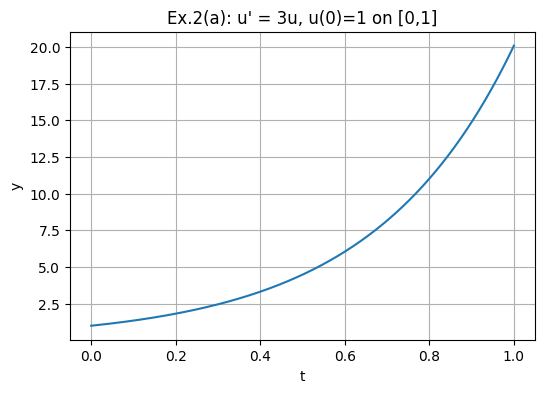

In [2]:
# (a) u' = 3u, 0 <= t <= 1, u(0)=1
f_a = lambda t, u: 3.0*u
t_a, u_a = rk4(f_a, (0.0, 1.0), 1.0, dt=1e-3)
lineplot(t_a, u_a, "Ex.2(a): u' = 3u, u(0)=1 on [0,1]")

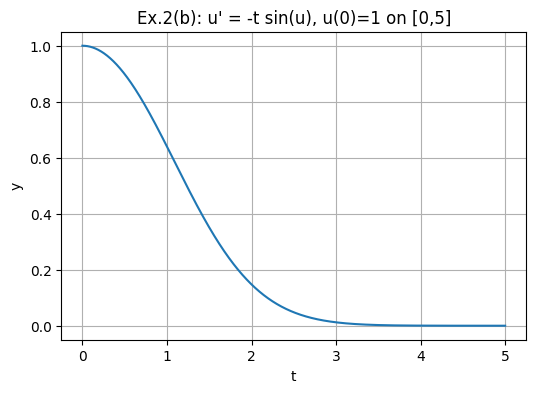

In [3]:
# (b) u' = -t*sin(u), 0 <= t <= 5, u(0)=1
f_b = lambda t, u: -t*np.sin(u)
t_b, u_b = rk4(f_b, (0.0, 5.0), 1.0, dt=2e-3)
lineplot(t_b, u_b, "Ex.2(b): u' = -t sin(u), u(0)=1 on [0,5]")

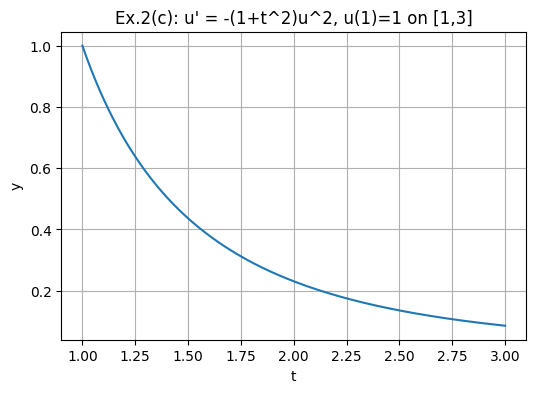

In [4]:
# (c) u' = -(1+t^2)u^2, 1 <= t <= 3, u(1)=1
# The exercise says "assume u is initially equal to 1 on the given interval".
# Here the interval starts at t=1, so the IVP is u(1)=1.
f_c = lambda t, u: -(1.0 + t**2)*u**2
t_c, u_c = rk4(f_c, (1.0, 3.0), 1.0, dt=2e-3)
lineplot(t_c, u_c, "Ex.2(c): u' = -(1+t^2)u^2, u(1)=1 on [1,3]")

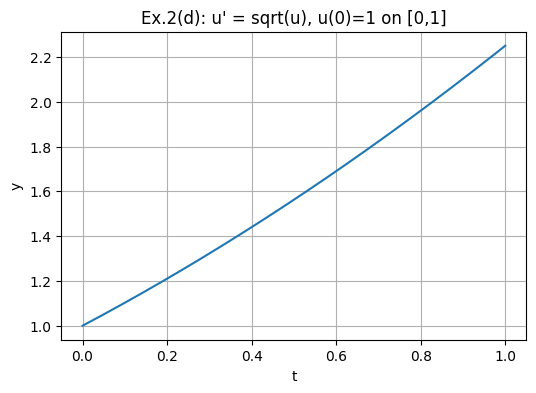

In [5]:
# (d) u' = sqrt(u), 0 <= t <= 1, u(0)=1
# sqrt is only defined for u >= 0; with u(0)=1 the solution stays nonnegative.
f_d = lambda t, u: np.sqrt(np.maximum(u, 0.0))
t_d, u_d = rk4(f_d, (0.0, 1.0), 1.0, dt=1e-3)
lineplot(t_d, u_d, "Ex.2(d): u' = sqrt(u), u(0)=1 on [0,1]")

## Exercise 5 — Logistic equation with harvesting
Solve $x' = k(S-x)(x-M)$ on $[0,10]$ with $k=S=1$, $M=0.25$ and initial conditions $x(0) \in \{0.9M, 1.1M, 1.5M, 0.9S, 1.1S, 3S\}$. Plot all solutions together.

C:\Users\pengu\AppData\Local\Temp\ipykernel_28008\512969091.py:5: RuntimeWarning: overflow encountered in multiply
  return k*(S - x)*(x - M)


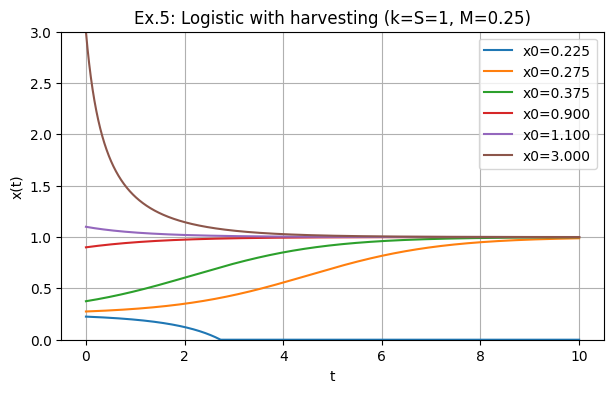

In [6]:
k, S, M = 1.0, 1.0, 0.25
inits = [0.9*M, 1.1*M, 1.5*M, 0.9*S, 1.1*S, 3.0*S]

def f_logistic(t, x):
    return k*(S - x)*(x - M)

t5 = None
sols5 = []
for x0 in inits:
    t, x = rk4(f_logistic, (0.0, 10.0), x0, dt=2e-3)
    if t5 is None:
        t5 = t
    sols5.append((x0, x))

plt.figure(figsize=(7,4))
for x0, x in sols5:
    plt.plot(t5, np.clip(x, 0.0, 3.0), label=f"x0={x0:.3f}")
plt.ylim([0.0, 3.0])
plt.title("Ex.5: Logistic with harvesting (k=S=1, M=0.25)")
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.legend()
plt.show()

## Exercise 6 — $u' = u\cos u + \cos(4t)$, multiple initial conditions
(a) Solve for $u(0) = u_0$ with $u_0 \in \{-2,-1.5,-1,\ldots,1.5,2\}$ and plot all solutions on one graph.

(b) To two digits of accuracy, find the value of $u_0\in(-1,1)$ at which the long-term periodic state switches.

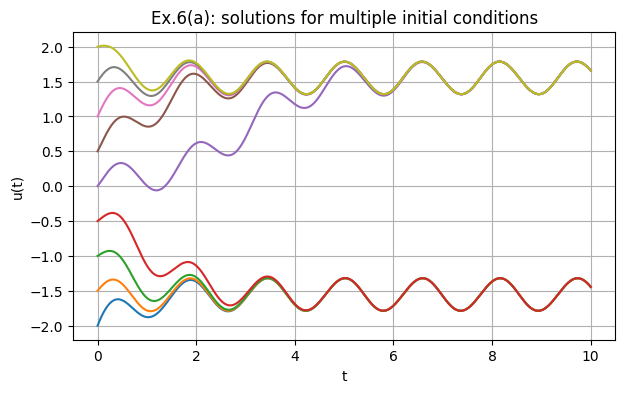

Approximate switching initial value in (-1,1): u0 ≈ -0.06


In [7]:
f6 = lambda t, u: u*np.cos(u) + np.cos(4.0*t)

# (a)
u0_list = np.round(np.arange(-2.0, 2.0+0.001, 0.5), 2)
plt.figure(figsize=(7,4))
for u0 in u0_list:
    t, u = rk4(f6, (0.0, 10.0), u0, dt=1e-3)
    plt.plot(t, u, label=f"u0={u0:.2f}")
plt.title("Ex.6(a): solutions for multiple initial conditions")
plt.xlabel("t")
plt.ylabel("u(t)")
plt.grid(True)
plt.show()

# (b) separatrix via bisection on the long-term mean sign
def classify_long_term(u0, T=100.0, dt=1e-3):
    t, u = rk4(f6, (0.0, T), u0, dt=dt)
    m = int(0.8*len(u))
    mean_tail = float(np.mean(u[m:]))
    return 1 if mean_tail >= 0.0 else -1

lo, hi = -1.0, 1.0
f_lo = classify_long_term(lo)
f_hi = classify_long_term(hi)

if f_lo == f_hi:
    for delta in [0.2, 0.3, 0.4]:
        lo2, hi2 = -1.0 - delta, 1.0 + delta
        f_lo, f_hi = classify_long_term(lo2), classify_long_term(hi2)
        if f_lo != f_hi:
            lo, hi = lo2, hi2
            break

for _ in range(30):
    mid = 0.5*(lo + hi)
    fm = classify_long_term(mid)
    if fm == f_lo:
        lo, f_lo = mid, fm
    else:
        hi, f_hi = mid, fm

u0_star = round(0.5*(lo + hi), 2)
print(f"Approximate switching initial value in (-1,1): u0 ≈ {u0_star:.2f}")

## Exercise 7 — Caffeine kinetics with piecewise input
$x'(t) = -k\,x + C(t),\quad x(0)=0,\; k=\log(2)/6.$  C(t)=16 for 0≤t≤0.5 and 0 afterwards. Plot for 12 hours, then repeat with a half-life of 8 hours.

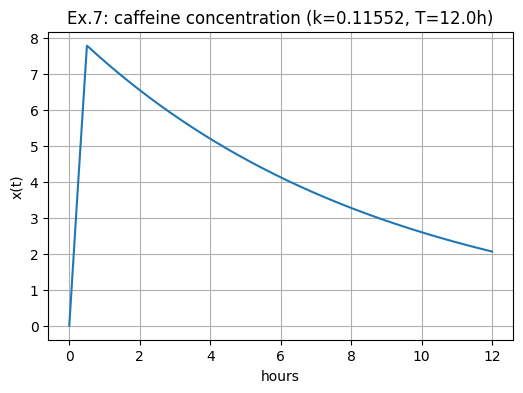

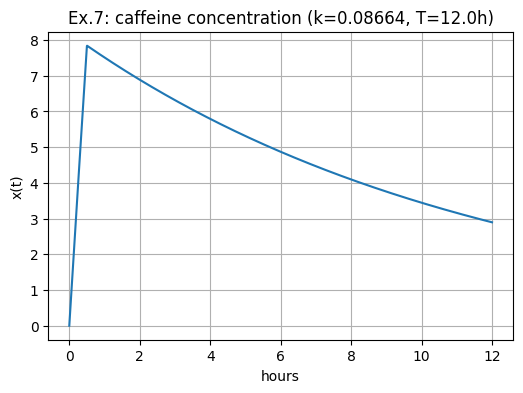

In [8]:
def caffeine_rhs(k):
    def C(t):
        return 16.0 if (0.0 <= t <= 0.5) else 0.0
    return lambda t, x: -k*x + C(t)

def run_caffeine(k, T=12.0):
    f = caffeine_rhs(k)
    t, x = rk4(f, (0.0, T), 0.0, dt=5e-3)
    lineplot(t, x, f"Ex.7: caffeine concentration (k={k:.5f}, T={T}h)", xlabel="hours", ylabel="x(t)")

k1 = math.log(2)/6.0
run_caffeine(k1, T=12.0)

k2 = math.log(2)/8.0  # half-life 8 hours
run_caffeine(k2, T=12.0)

## Exercise 8 — Skydiver with piecewise drag, altitude, and touchdown time
Model: $v'(t)=-g+\frac{k(t)}{m}v^2$, $v(0)=0$, with $g=9.8\,\mathrm{m/s^2}$, $m=80\,\mathrm{kg}$. Drag $k(t)=0.4875$ for $t<13$ s and $k(t)=29.16$ for $t\ge 13$ s. Initial altitude is 1200 m.

(a) Solve and plot $v(t)$ for $t\in[0,200]$.

(b) Compute altitude $h(t)=1200-\int_0^t v(s)\,ds$ and plot it.

(c) Find the touchdown time accurately (root of $h(t)$).

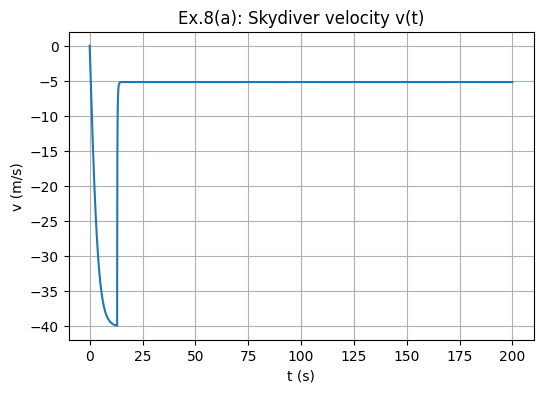

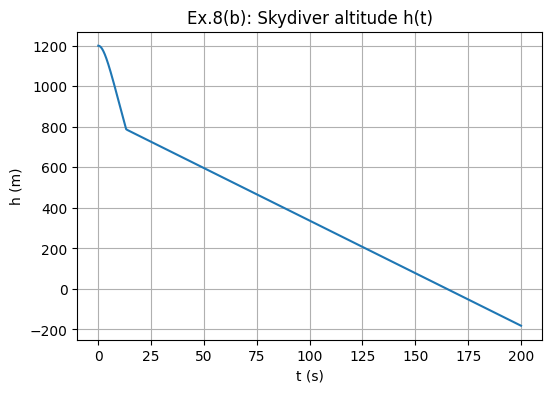

Estimated touchdown time: t ≈ 124.277 s


In [9]:
g = 9.8
m = 80.0

def k_drag(t):
    return 0.4875 if t < 13.0 else 29.16

def f_skydiver(t, v):
    return -g + (k_drag(t)/m)*(v**2)

# (a) solve to 200 s
t8, v8 = rk4(f_skydiver, (0.0, 200.0), 0.0, dt=1e-3)
lineplot(t8, v8, "Ex.8(a): Skydiver velocity v(t)", xlabel="t (s)", ylabel="v (m/s)")

# (b) altitude via cumulative trapezoid; here h' = v and v is negative (downward),
# so h(t) = H0 + ∫ v(s) ds
def cumulative_trapz(t, y):
    area = np.zeros_like(y)
    for i in range(1, len(t)):
        h = t[i] - t[i-1]
        area[i] = area[i-1] + 0.5*h*(y[i] + y[i-1])
    return area

H0 = 1200.0
dist = cumulative_trapz(t8, v8)  # signed displacement (negative)
h8 = H0 + dist
lineplot(t8, h8, "Ex.8(b): Skydiver altitude h(t)", xlabel="t (s)", ylabel="h (m)")

# (c) touchdown time: find t where h crosses 0 using bisection.
def h_of_t(T):
    tt, vv = rk4(f_skydiver, (0.0, T), 0.0, dt=2e-3)
    dd = cumulative_trapz(tt, vv)
    if dd.size == 1:
        return H0 + dd
    return H0 + dd[-1]

a, b = 0.0, 200.0
ha, hb = h_of_t(a), h_of_t(b)
while hb > 0 and b < 2000:  # ensure we bracket
    b *= 2.0
    hb = h_of_t(b)

for _ in range(50):
    m = 0.5*(a + b)
    hm = h_of_t(m)
    if hm > 0:
        a, ha = m, hm
    else:
        b, hb = m, hm

t_touchdown = 0.5*(a + b)
print(f"Estimated touchdown time: t ≈ {t_touchdown:.3f} s")